In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


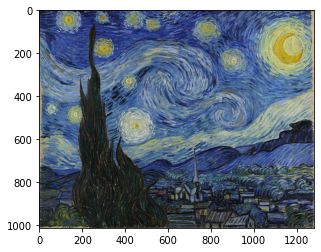

In [ ]:
import torch
import skimage.io as io
import matplotlib.pyplot as plt
from PIL import Image
import torchvision.transforms as T
import copy
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.models as models

DEVICE = torch.device("cuda:0")
SIZE = 512
EPOCHS = 100
STYLE_PATH = '/content/drive/MyDrive/Colab Notebooks/style_trans/input/starry-night.jpg'
STYLE_WEIGHT = 100000
CONTENT_PATH = '/content/drive/MyDrive/Colab Notebooks/style_trans/input/main_quad.jpg'
CONTENT_WEIGHT = 1
OUTPUT_PATH = '/content/drive/MyDrive/Colab Notebooks/style_trans/output/out.png'

sty_img = io.imread(STYLE_PATH)
sty_show = plt.imshow(sty_img)


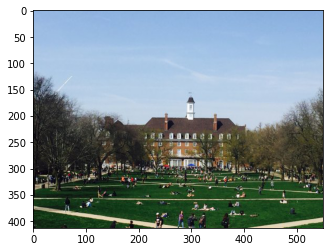

In [ ]:
cont_img = Image.open(CONTENT_PATH).convert('RGB')
cont_show = plt.imshow(cont_img)

In [ ]:
import copy
import torch
import torch.nn as nn
import torch.nn.functional as F

# Content Loss Layer
class ContentLoss_layer(nn.Module):
	def __init__(self, target):
		super(ContentLoss_layer, self).__init__()
		self.target = target

	def forward(self, input):
		self.loss = F.mse_loss(input, self.target.detach())
		return input

# Style Loss Layer
class StyleLoss_layer(nn.Module):
  def __init__(self, target_feature):
    super(StyleLoss_layer, self).__init__()
    a,b,c,d = target_feature.size()
    temp = target_feature.view(a*b,c*d)
    tmx = torch.mm(temp, temp.t()).div(a*b*c*d)
    self.target = tmx.detach()
  
  def forward(self, input):
    a, b, c, d = input.size()
    features = input.view(a* b, c*d)
    trans = features.t()
    #gram matrix
    Gmx = torch.mm(features, trans).div(a*b*c*d)
    self.loss = F.mse_loss(Gmx, self.target)
    return input


# Normalization Layer to transform input images
class Normalization(nn.Module):
	def __init__(self, mean, std):
		super(Normalization, self).__init__()
		self.mean = mean
		self.std = std

	def forward(self, image):
		return (image - torch.tensor(self.mean).view(-1, 1, 1))/ torch.tensor(self.std).view(-1, 1, 1)

# Create our model with our loss layers
def style_cnn(cnn, device, normalization_mean, normalization_std, style_image, content_image):
  # marked layers which we want to change something
  style_layers = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5']
  # losses track
  style_losses,content_losses = [],[]
  cnn = copy.deepcopy(cnn)



  # initial normalization at first
  normalization = Normalization(normalization_mean, normalization_std).to(device)
  model = nn.Sequential(normalization)

  # Keep track of convolutional layers
  i = 0
	# Loop through vgg layers and add layers
  for layer in cnn.children():
    if isinstance(layer, nn.Conv2d):
      i += 1
      name = 'conv_'+str(i)
      model.add_module(name, layer)
    elif isinstance(layer, nn.ReLU):
      name = 'relu_'+str(i)
      layer = nn.ReLU(inplace=False)
      model.add_module(name, layer)
    elif isinstance(layer, nn.MaxPool2d):
      name = 'pool_'+str(i)
      model.add_module(name, layer)
    elif isinstance(layer, nn.BatchNorm2d):
      name = 'bn_'+str(i)
      model.add_module(name, layer)
    else:
      model.add_module(name, layer)


    
    if name in style_layers:
      target_feature = model(style_image).detach()
      style_loss = StyleLoss_layer(target_feature)
      model.add_module('style_loss_'+str(i), style_loss)
      style_losses.append(style_loss)

    # Add our content loss layer
    if name =='conv_4':
      target = model(content_image).detach()
      content_loss = ContentLoss_layer(target)
      model.add_module('content_loss_'+str(i), content_loss)
      content_losses.append(content_loss)

  # Cut the useless layers
  Deep = len(model)
  while(Deep):
    Deep-=1
    current_layer = model[Deep]
    if isinstance(current_layer, StyleLoss_layer or ContentLoss_layer):
      break

  return model[0:(Deep+1)], style_losses, content_losses

In [ ]:

import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.models as models
from PIL import Image

#trans the 
img_tensor = T.Compose([
  T.Resize(SIZE),
  T.CenterCrop(SIZE),
  T.ToTensor()
])


def load_image(path):

	image = img_tensor(Image.open(path)).unsqueeze(0)
	return image.to(DEVICE, torch.float)

def save_image(tensor, path):
  unloader = T.ToPILImage()
  image = unloader(tensor.cpu().clone().squeeze(0))
  image.save(path)


style_image = load_image(STYLE_PATH)
content_image = load_image(CONTENT_PATH)

# Load Pretrained VGG and Normalization Tensors
cnn = models.vgg19(pretrained=True).features.to(DEVICE).eval()

# Build the model
model, style_losses, content_losses = style_cnn(cnn, DEVICE, 
	torch.tensor([0.485, 0.456, 0.406]).to(DEVICE), torch.tensor([0.229, 0.224, 0.225]).to(DEVICE), style_image, content_image)

print(model)

Sequential(
  (0): Normalization()
  (conv_1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (style_loss_1): StyleLoss()
  (relu_1): ReLU()
  (conv_2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (style_loss_2): StyleLoss()
  (relu_2): ReLU()
  (pool_2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv_3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (style_loss_3): StyleLoss()
  (relu_3): ReLU()
  (conv_4): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (style_loss_4): StyleLoss()
  (content_loss_4): ContentLoss_layer()
  (relu_4): ReLU()
  (pool_4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv_5): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (style_loss_5): StyleLoss()
)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:43: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:43: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



EPOCHS: 100
Final Total Loss: 16.380165



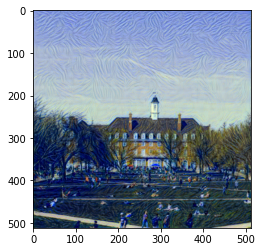

In [ ]:
# Optimization algorithm
trans_img = content_image.clone()
optimizer = optim.LBFGS([trans_img.requires_grad_()])

x=0
Bar = trange(EPOCHS//20)
for i in Bar:
  Bar.set_description('Training:')
	# Closure function is needed for LBFGS algorithm
  def closure():
    # Keep target values between 0 and 1
    trans_img.data.clamp_(0, 1)

    optimizer.zero_grad()
    model(trans_img)
    style_score = 0
    content_score = 0

    for s1 in style_losses:
      style_score += s1.loss
    for c1 in content_losses:
      content_score += c1.loss

    style_score *= STYLE_WEIGHT
    content_score *= CONTENT_WEIGHT

    loss = style_score + content_score
    loss.backward()
    

    return loss
  x=optimizer.step(closure)
trans_img.data.clamp_(0, 1)
save_image(trans_img, OUTPUT_PATH)
trans_img = io.imread(OUTPUT_PATH)
trans_show = plt.imshow(trans_img)
print('EPOCHS:',EPOCHS)
print('Final Total Loss: {:4f}'.format(x))
print( )